In [1]:
!pip install yfinance

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import pickle

In [3]:
df = pd.read_csv("/content/aapl_ticker.csv")
df.head()

,Open,High,Low,Close,Adj Close,Volume
0,74.059998,75.150002,73.797501,75.087502,73.059425,135480400
1,74.287498,75.144997,74.125000,74.357498,72.349144,146322800
2,73.447502,74.989998,73.187500,74.949997,72.925636,118387200
3,74.959999,75.224998,74.370003,74.597504,72.582649,108872000
4,74.290001,76.110001,74.290001,75.797501,73.750244,132079200


In [4]:
#Using index as Time
data = df['Close']

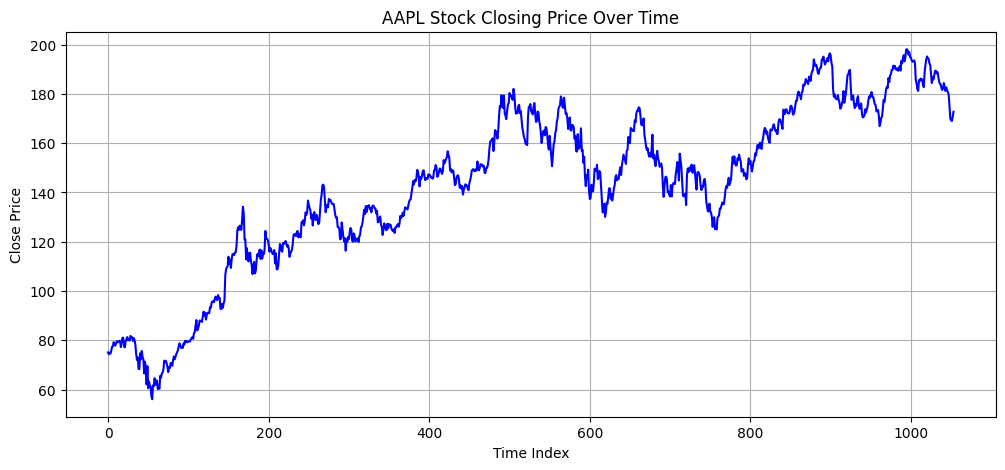

In [5]:
#Visualize Raw Data
plt.figure(figsize=(12,5))
plt.plot(data.values, color='blue')
plt.title("AAPL Stock Closing Price Over Time")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

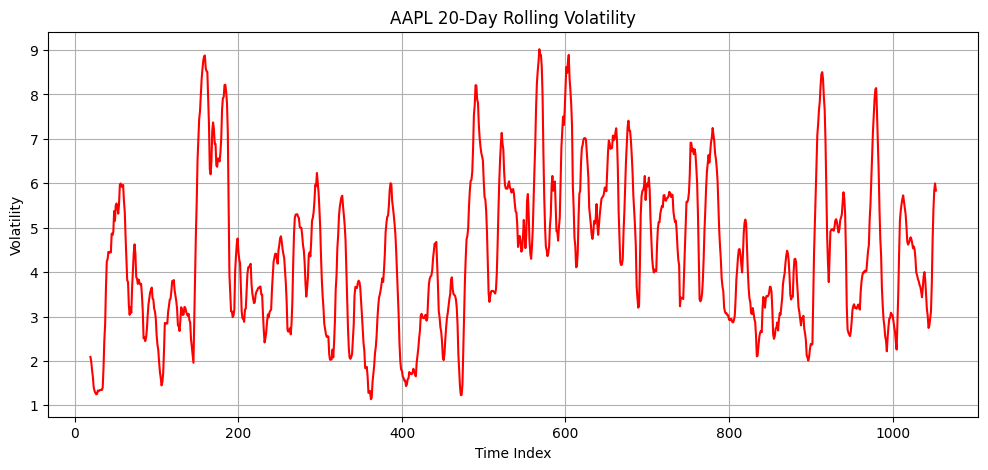

In [6]:
#Calculate Volatility (rolling std)
volatility = data.rolling(window=20).std()
plt.figure(figsize=(12,5))
plt.plot(volatility.values, color='red')
plt.title("AAPL 20-Day Rolling Volatility")
plt.xlabel("Time Index")
plt.ylabel("Volatility")
plt.grid(True)
plt.show()

In [8]:
# Scale Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data.values.reshape(-1,1))


with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)


In [9]:
# Create 60-day sequences
X, y = [], []
sequence_length = 60
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i,0])
    y.append(scaled_data[i,0])
X = np.array(X)
y = np.array(y)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Build LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
#Train Model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.2410 - val_loss: 0.0144
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0121 - val_loss: 0.0027
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0077 - val_loss: 0.0019
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0065 - val_loss: 0.0016
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0060 - val_loss: 0.0021
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0058 - val_loss: 0.0017
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0055 - val_loss: 0.0016
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0052 - val_loss: 0.0015
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0047 - val_loss: 0.0014
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0050 - val_loss: 0.0018
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0047 - val_loss: 0.0014
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0

In [15]:
# Predictions on test set
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1,1))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [16]:
# RMSE
rmse = np.sqrt(mean_squared_error(real_prices, predicted_prices))
print("Test RMSE:", rmse)

Test RMSE: 4.985252344053779


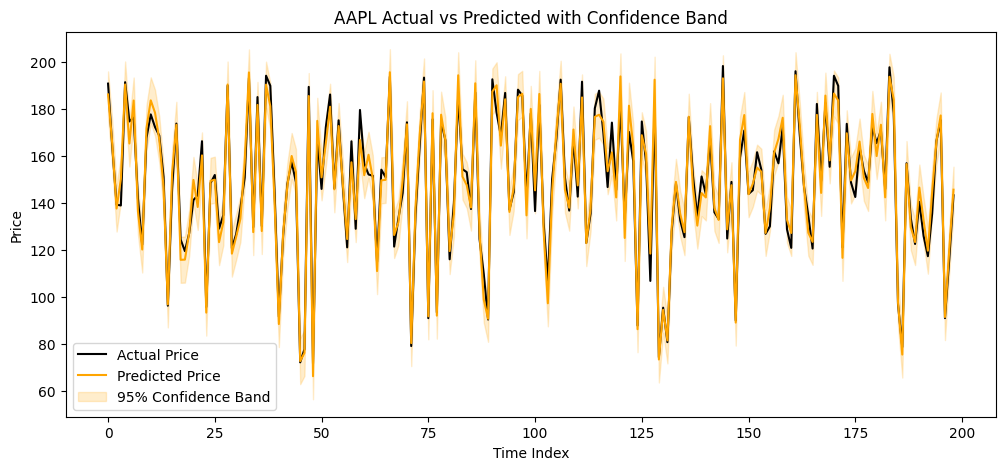

In [18]:
# Actual vs Predicted Plot + Confidence Band
std_dev = np.std(predicted_prices - real_prices)  # simple std deviation of errors
upper_band = predicted_prices + 1.96*std_dev
lower_band = predicted_prices - 1.96*std_dev



plt.figure(figsize=(12,5))
plt.plot(real_prices, label="Actual Price", color='black')
plt.plot(predicted_prices, label="Predicted Price", color='orange')
plt.fill_between(range(len(predicted_prices)), lower_band.flatten(), upper_band.flatten(), color='orange', alpha=0.2, label="95% Confidence Band")
plt.title("AAPL Actual vs Predicted with Confidence Band")
plt.xlabel("Time Index")
plt.ylabel("Price")
plt.legend()
plt.show()

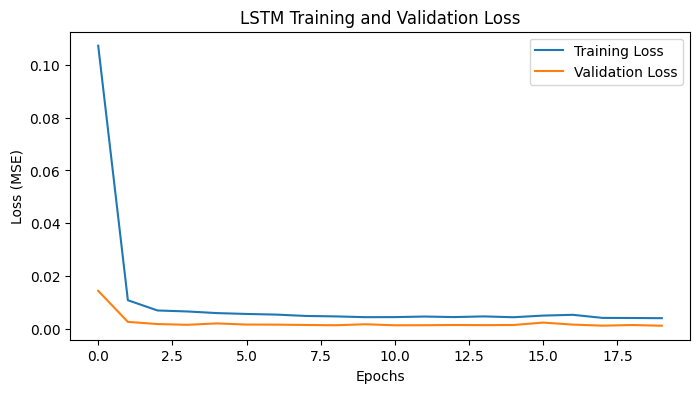

In [19]:
# Plot Training & Validation Loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("LSTM Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

In [20]:
# Predict next 7 days
last_60_days = scaled_data[-sequence_length:]  # last 60 days
next_days_predictions = []

current_batch = last_60_days.reshape(1, sequence_length, 1)

for i in range(7):
    pred = model.predict(current_batch)[0,0]
    next_days_predictions.append(pred)
    current_batch = np.append(current_batch[:,1:,:], [[ [pred] ]], axis=1)

next_days_predictions = scaler.inverse_transform(np.array(next_days_predictions).reshape(-1,1))
print("Next 7 Days Predicted Prices:\n", next_days_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Next 7 Days Predicted Prices:
 [[174.79066]
 [174.04366]
 [173.54349]
 [173.21735]
 [173.01227]
 [172.89066]
 [172.82614]]


In [21]:
# Save LSTM Model
model.save("lstm_model.h5")
print("Model saved as lstm_model.h5 and scaler.pkl ready for deployment.")

Model saved as lstm_model.h5 and scaler.pkl ready for deployment.
